In [1]:
dataset <- "ARPAPiemonte"
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Piemonte"
match_dist <- 15000
new_dataset <- "PIE"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/integrazioni_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Valle D'Aosta", "Liguria", "Lombardia", "Emilia-Romagna"), !(network %in% c("Sinottica", "Mareografica")))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number()) |>
    filter((dataset == "ARPAPiemonte" & state == "Piemonte") | dataset != "ARPAPiemonte")
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
# analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", state, "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "integrazioni_regionali", state, "raw_analysis.parquet"))


In [5]:
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(require_all = TRUE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "integrazioni_regionali", state, "tagged_analysis.xlsx"), starts_with("tag_"))


In [6]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, merging_datasets, desc(dataset), desc(sensor_last))
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 15L, 0.5)


In [7]:
i <- incomp |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_y" = "key")) |>
    arrange(desc(abs(k0)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name.x,dataset.x,sensor_key.x,name.y,dataset.y,sensor_key.y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
121,1.0067334,0.180426546,-0.075610692,0.009525279,207,223,629,-1,0,FOSSANO,ARPAPiemonte,224,FOSSANO,ISAC,3893
60,-0.7993882,0.363471478,0.031428902,0.012512395,115,126,647,1,0,LOZZOLO,ARPAPiemonte,127,LOZZOLO,ISAC,3911
170,0.7441237,-0.044961324,0.044369917,-0.053103509,94,104,460,1,0,LAGO DIETRO LA TORRE,ARPAPiemonte,105,LAGO_DIETRO_LA_TORRE,ISAC,1499
436,0.7309665,-0.047687379,0.035887905,-0.015753832,228,248,494,1,0,MONVISO,ARPAPiemonte,249,MONVISO,ISAC,2031
438,0.6844859,-0.123257192,0.096857501,-0.049606650,229,249,421,1,0,COLLE DELL'AGNELLO,ARPAPiemonte,250,COLLE_DELL_AGNELLO,ISAC,949
374,0.6780171,-0.040793898,0.052700149,-0.039616797,196,210,519,1,0,PIAN GIASSET,ARPAPiemonte,211,PIAN_GIASSET,ISAC,2333
328,0.6716040,0.005400194,0.012597207,-0.011592294,173,186,328,1,0,ACCEGLIO COLLET,ARPAPiemonte,187,ACCEGLIO_COLLET,ISAC,39
10,0.6113908,-0.143822376,0.067421760,0.008741656,5,5,350,1,0,RIFUGIO GASTALDI,ARPAPiemonte,5,BALME_RIFUG_GASTALDI,ISAC,256
14,0.6066861,0.009061955,-0.029454067,0.045197869,26,29,409,1,0,CERESOLE VILLA,ARPAPiemonte,29,CERESOLE_VILLA,ISAC,832


In [8]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, 1)
db <- merged_checkpoint(merge_results, metadata, new_dataset)
rm(merge_results)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2142264,114.5,5671202,302.9,NA,5671202,302.9
Vcells,36110414,275.6,191952298,1464.5,16384,299894719,2288.1


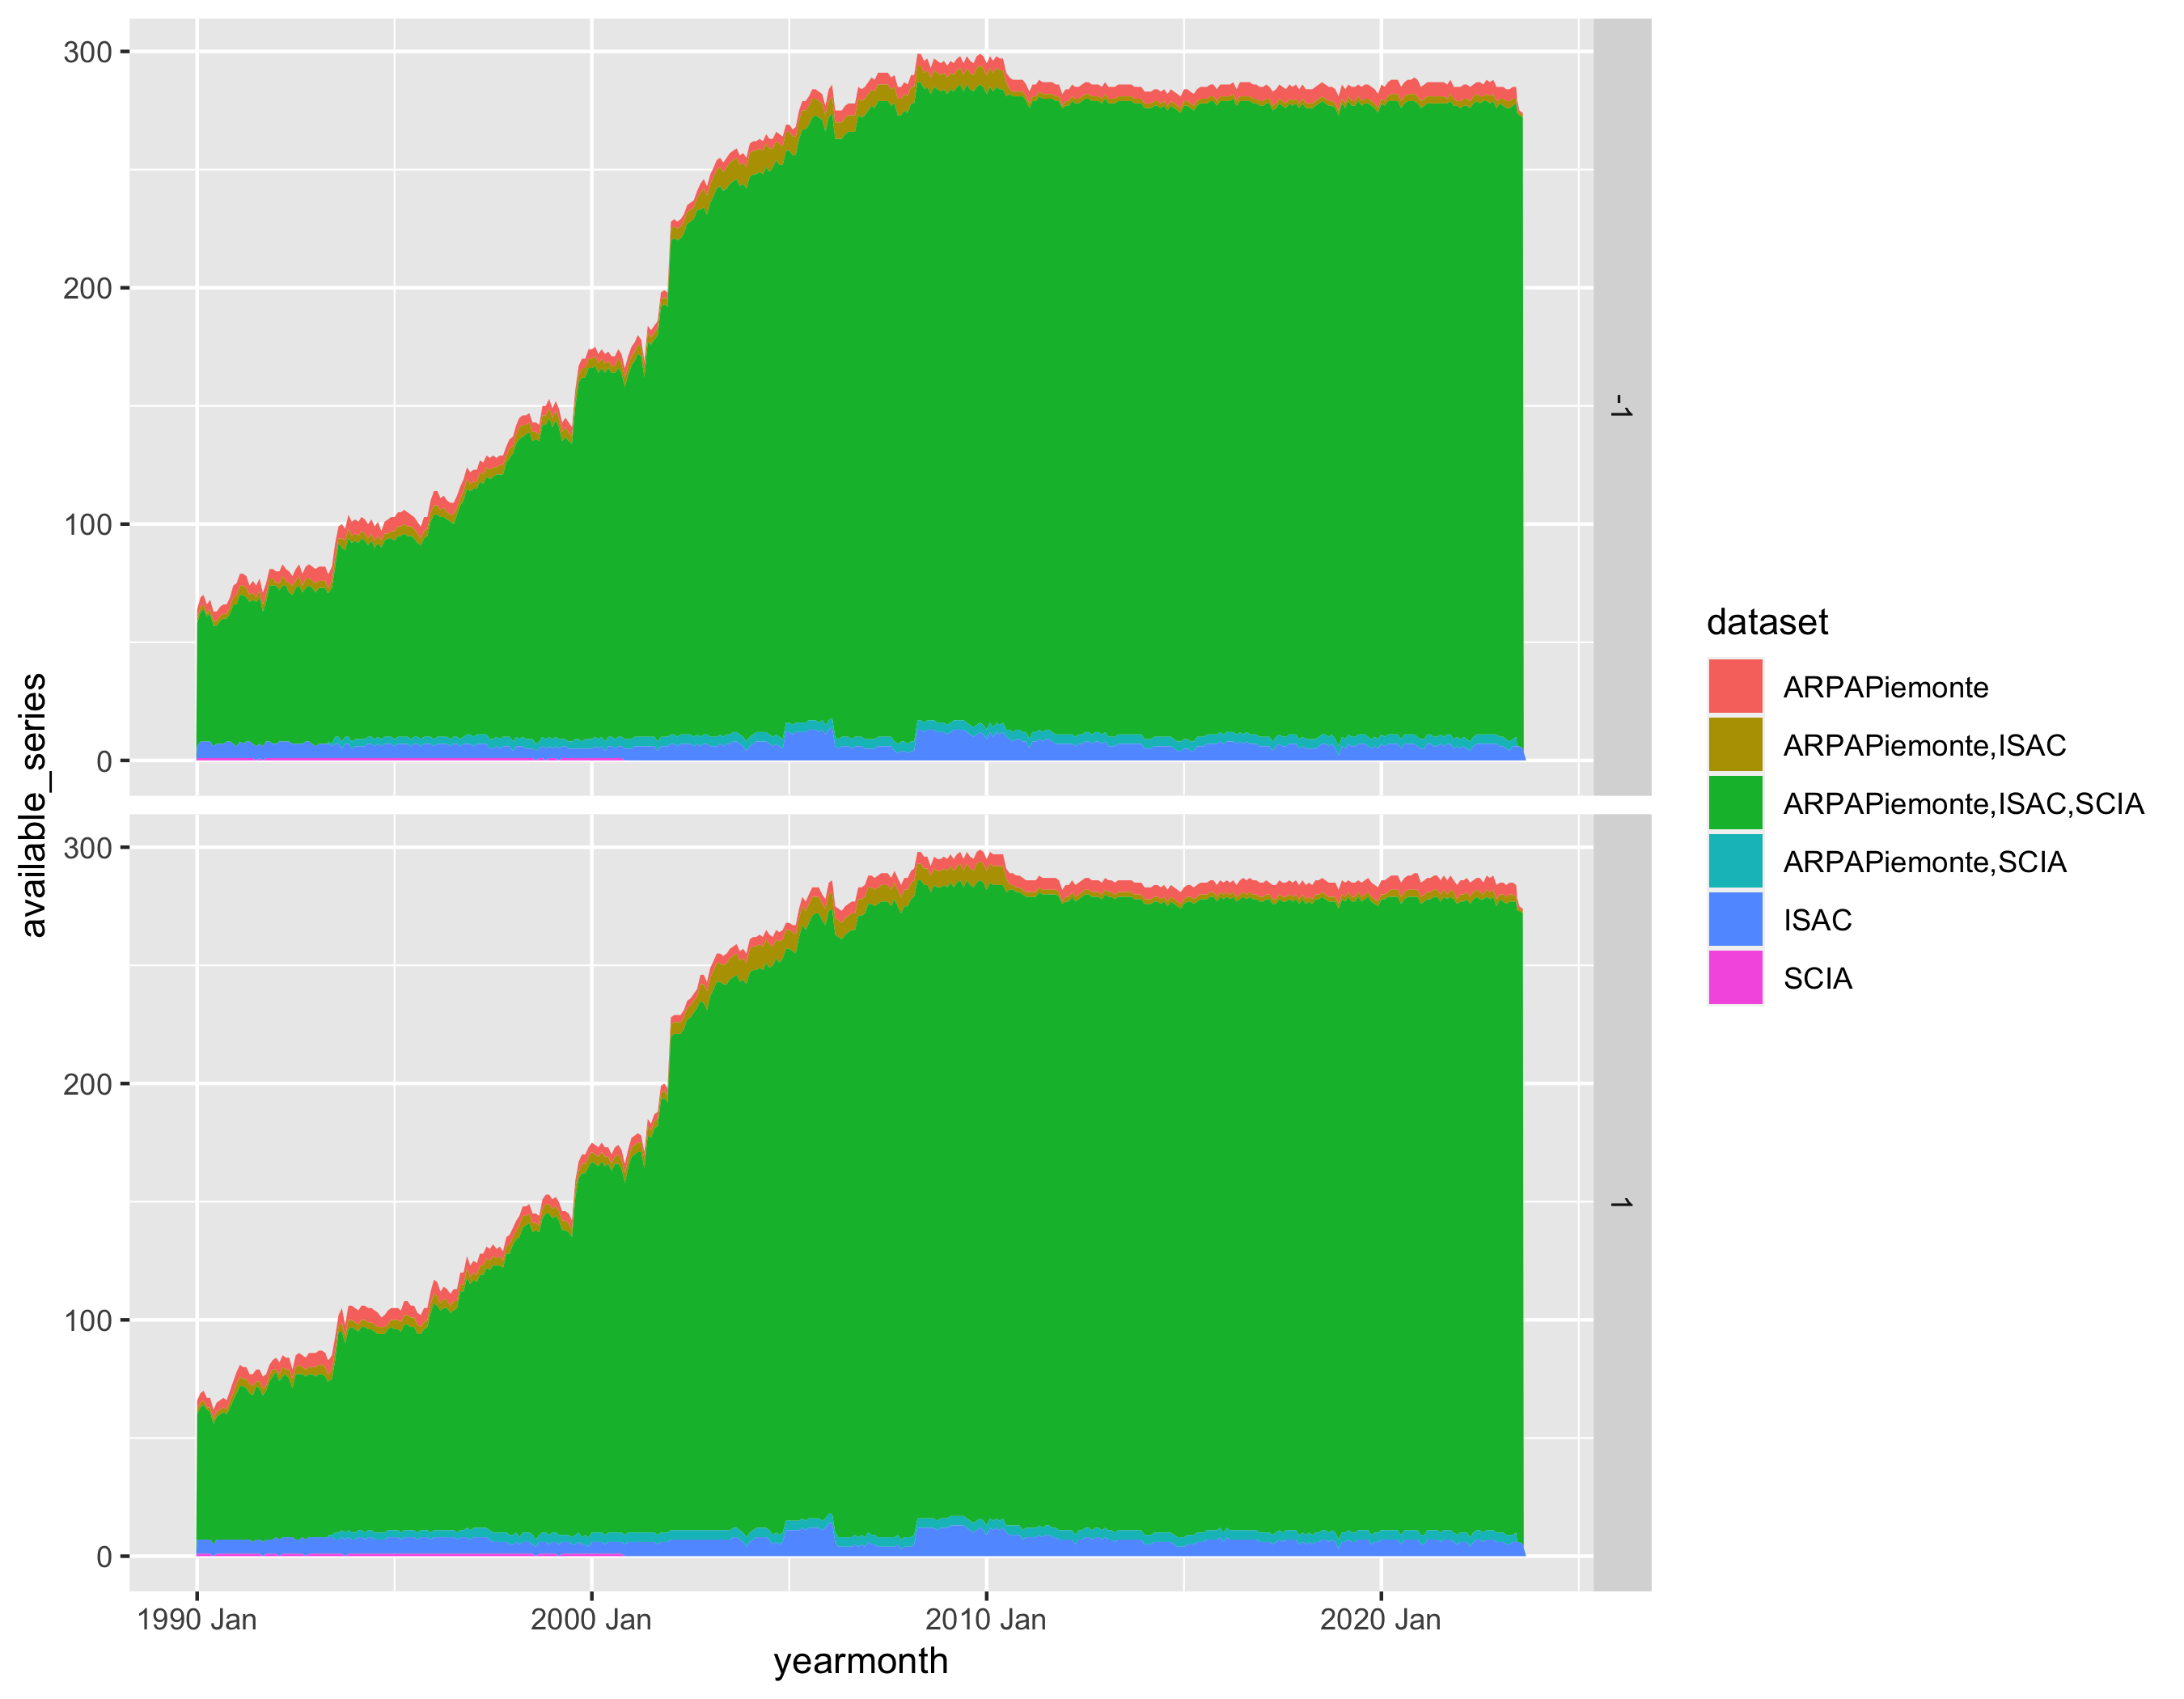

In [9]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


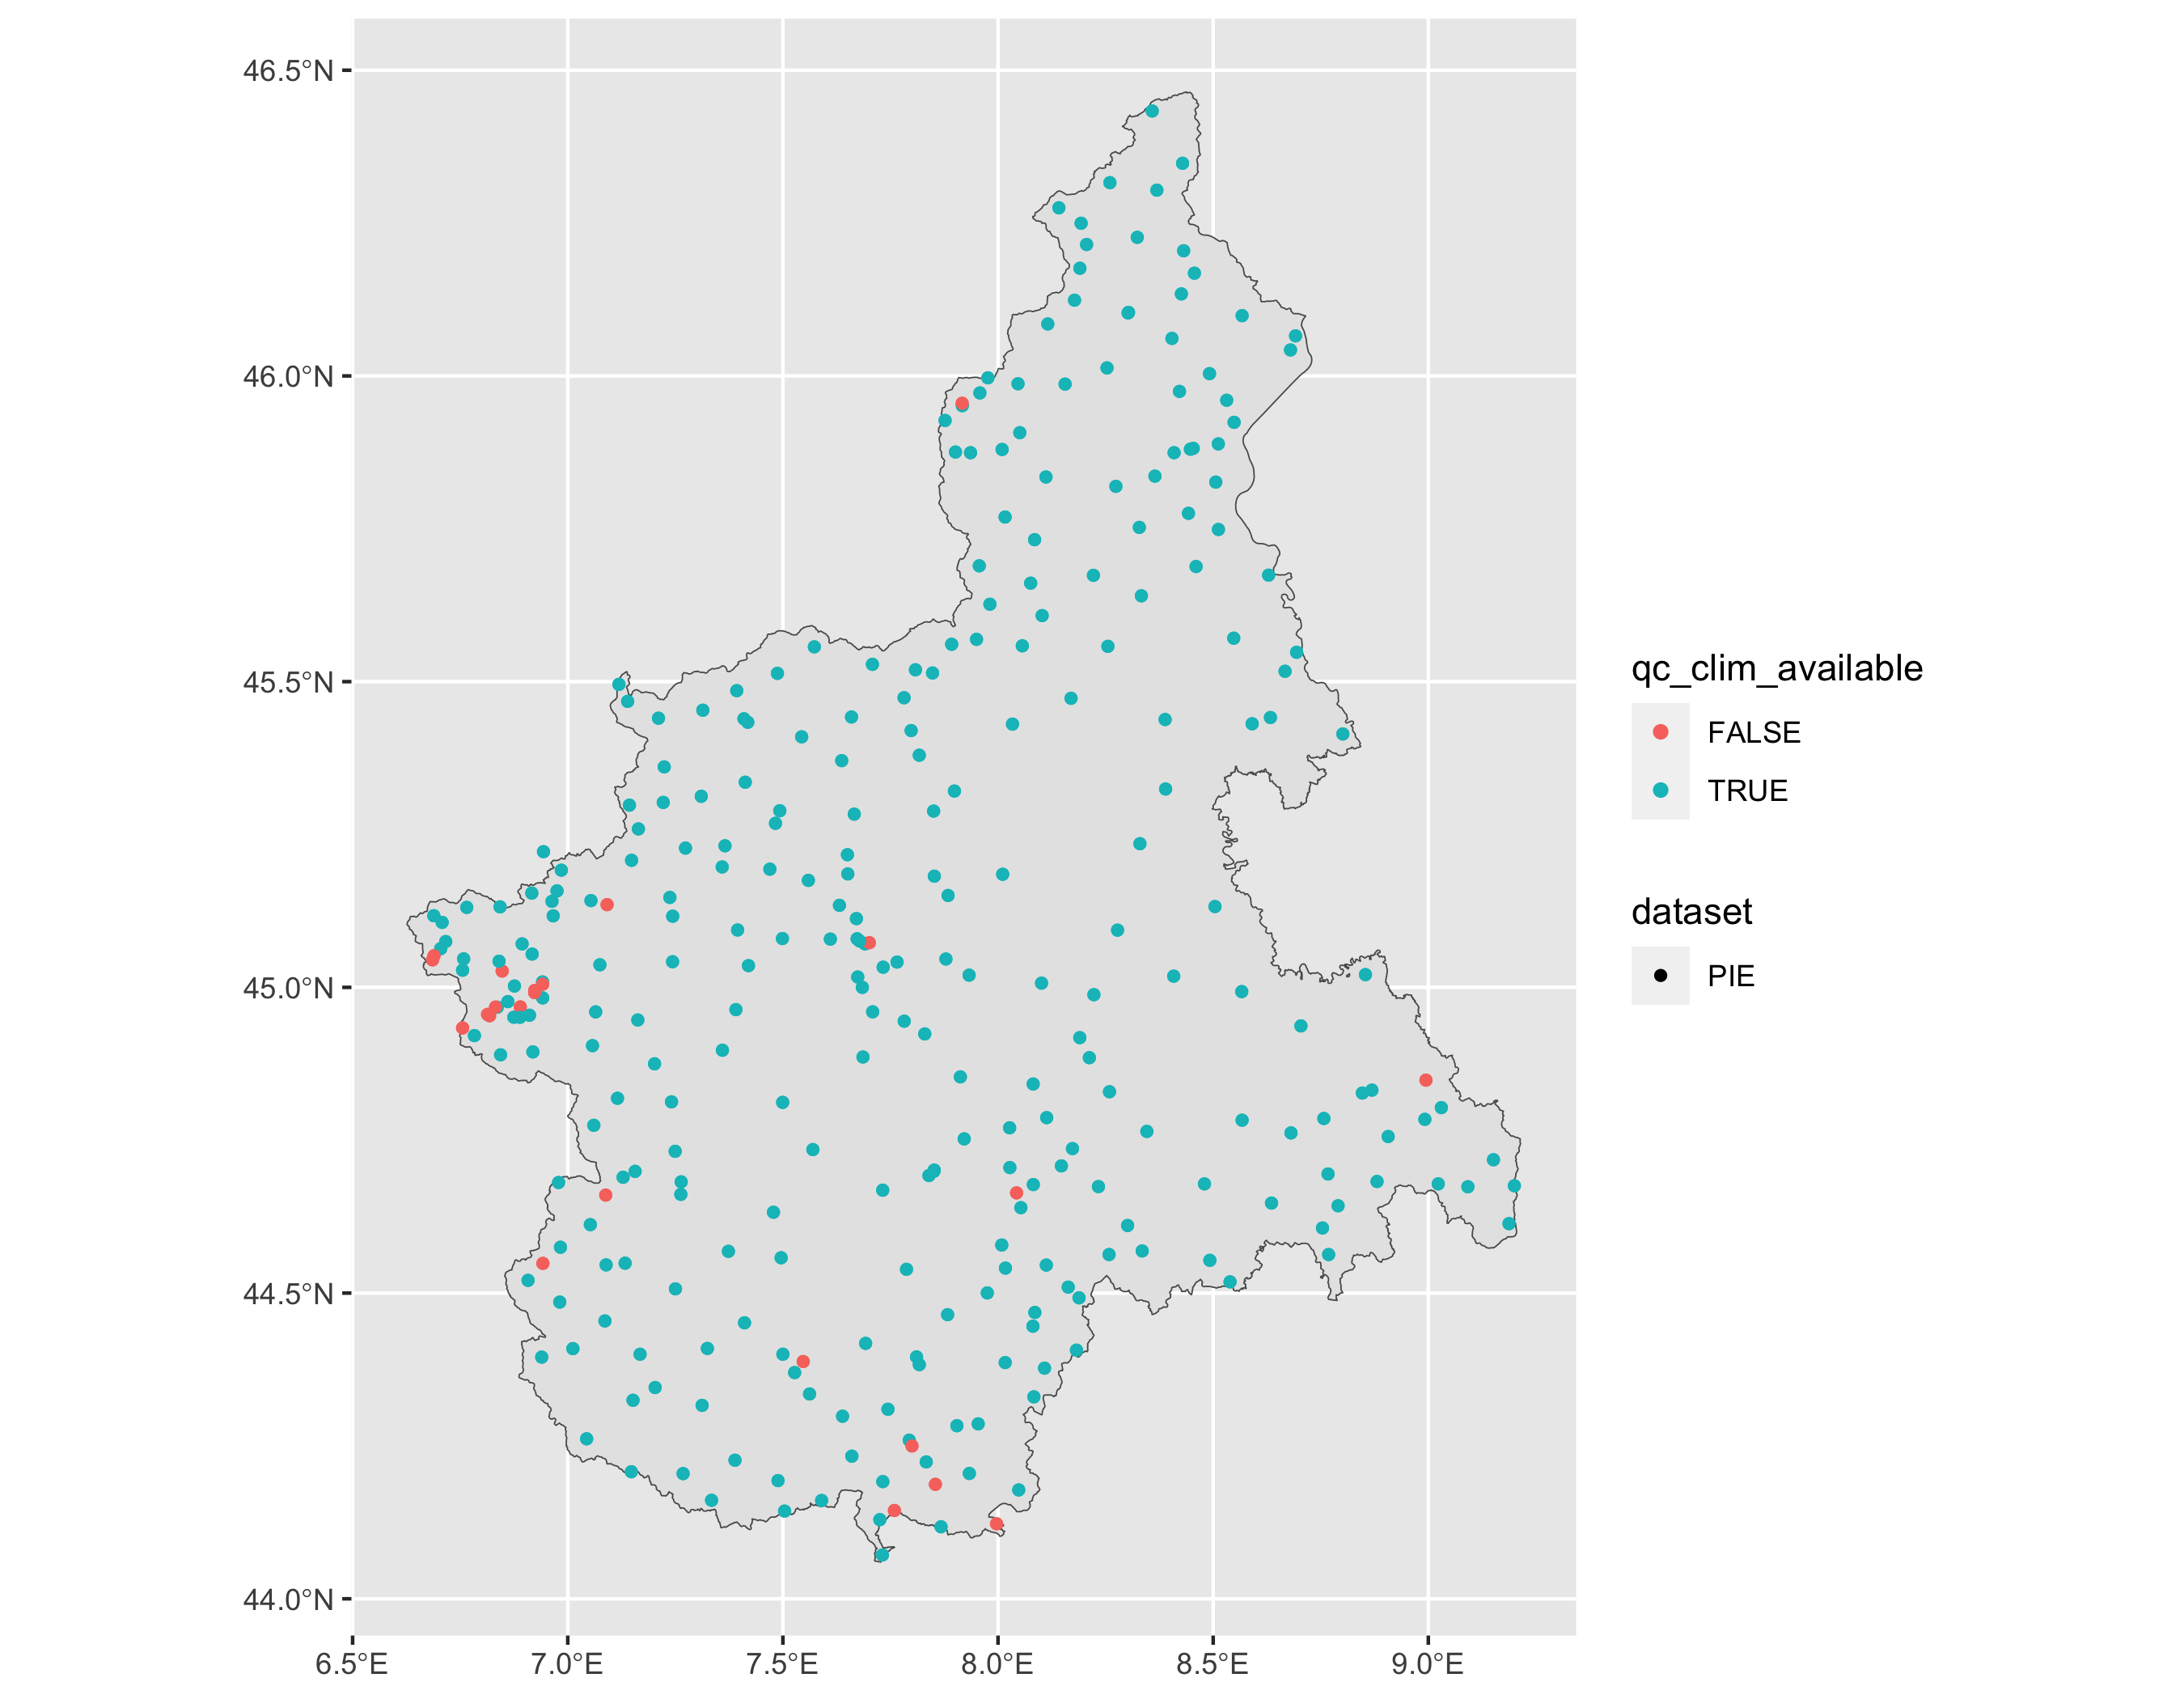

In [10]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries)
pd$plot


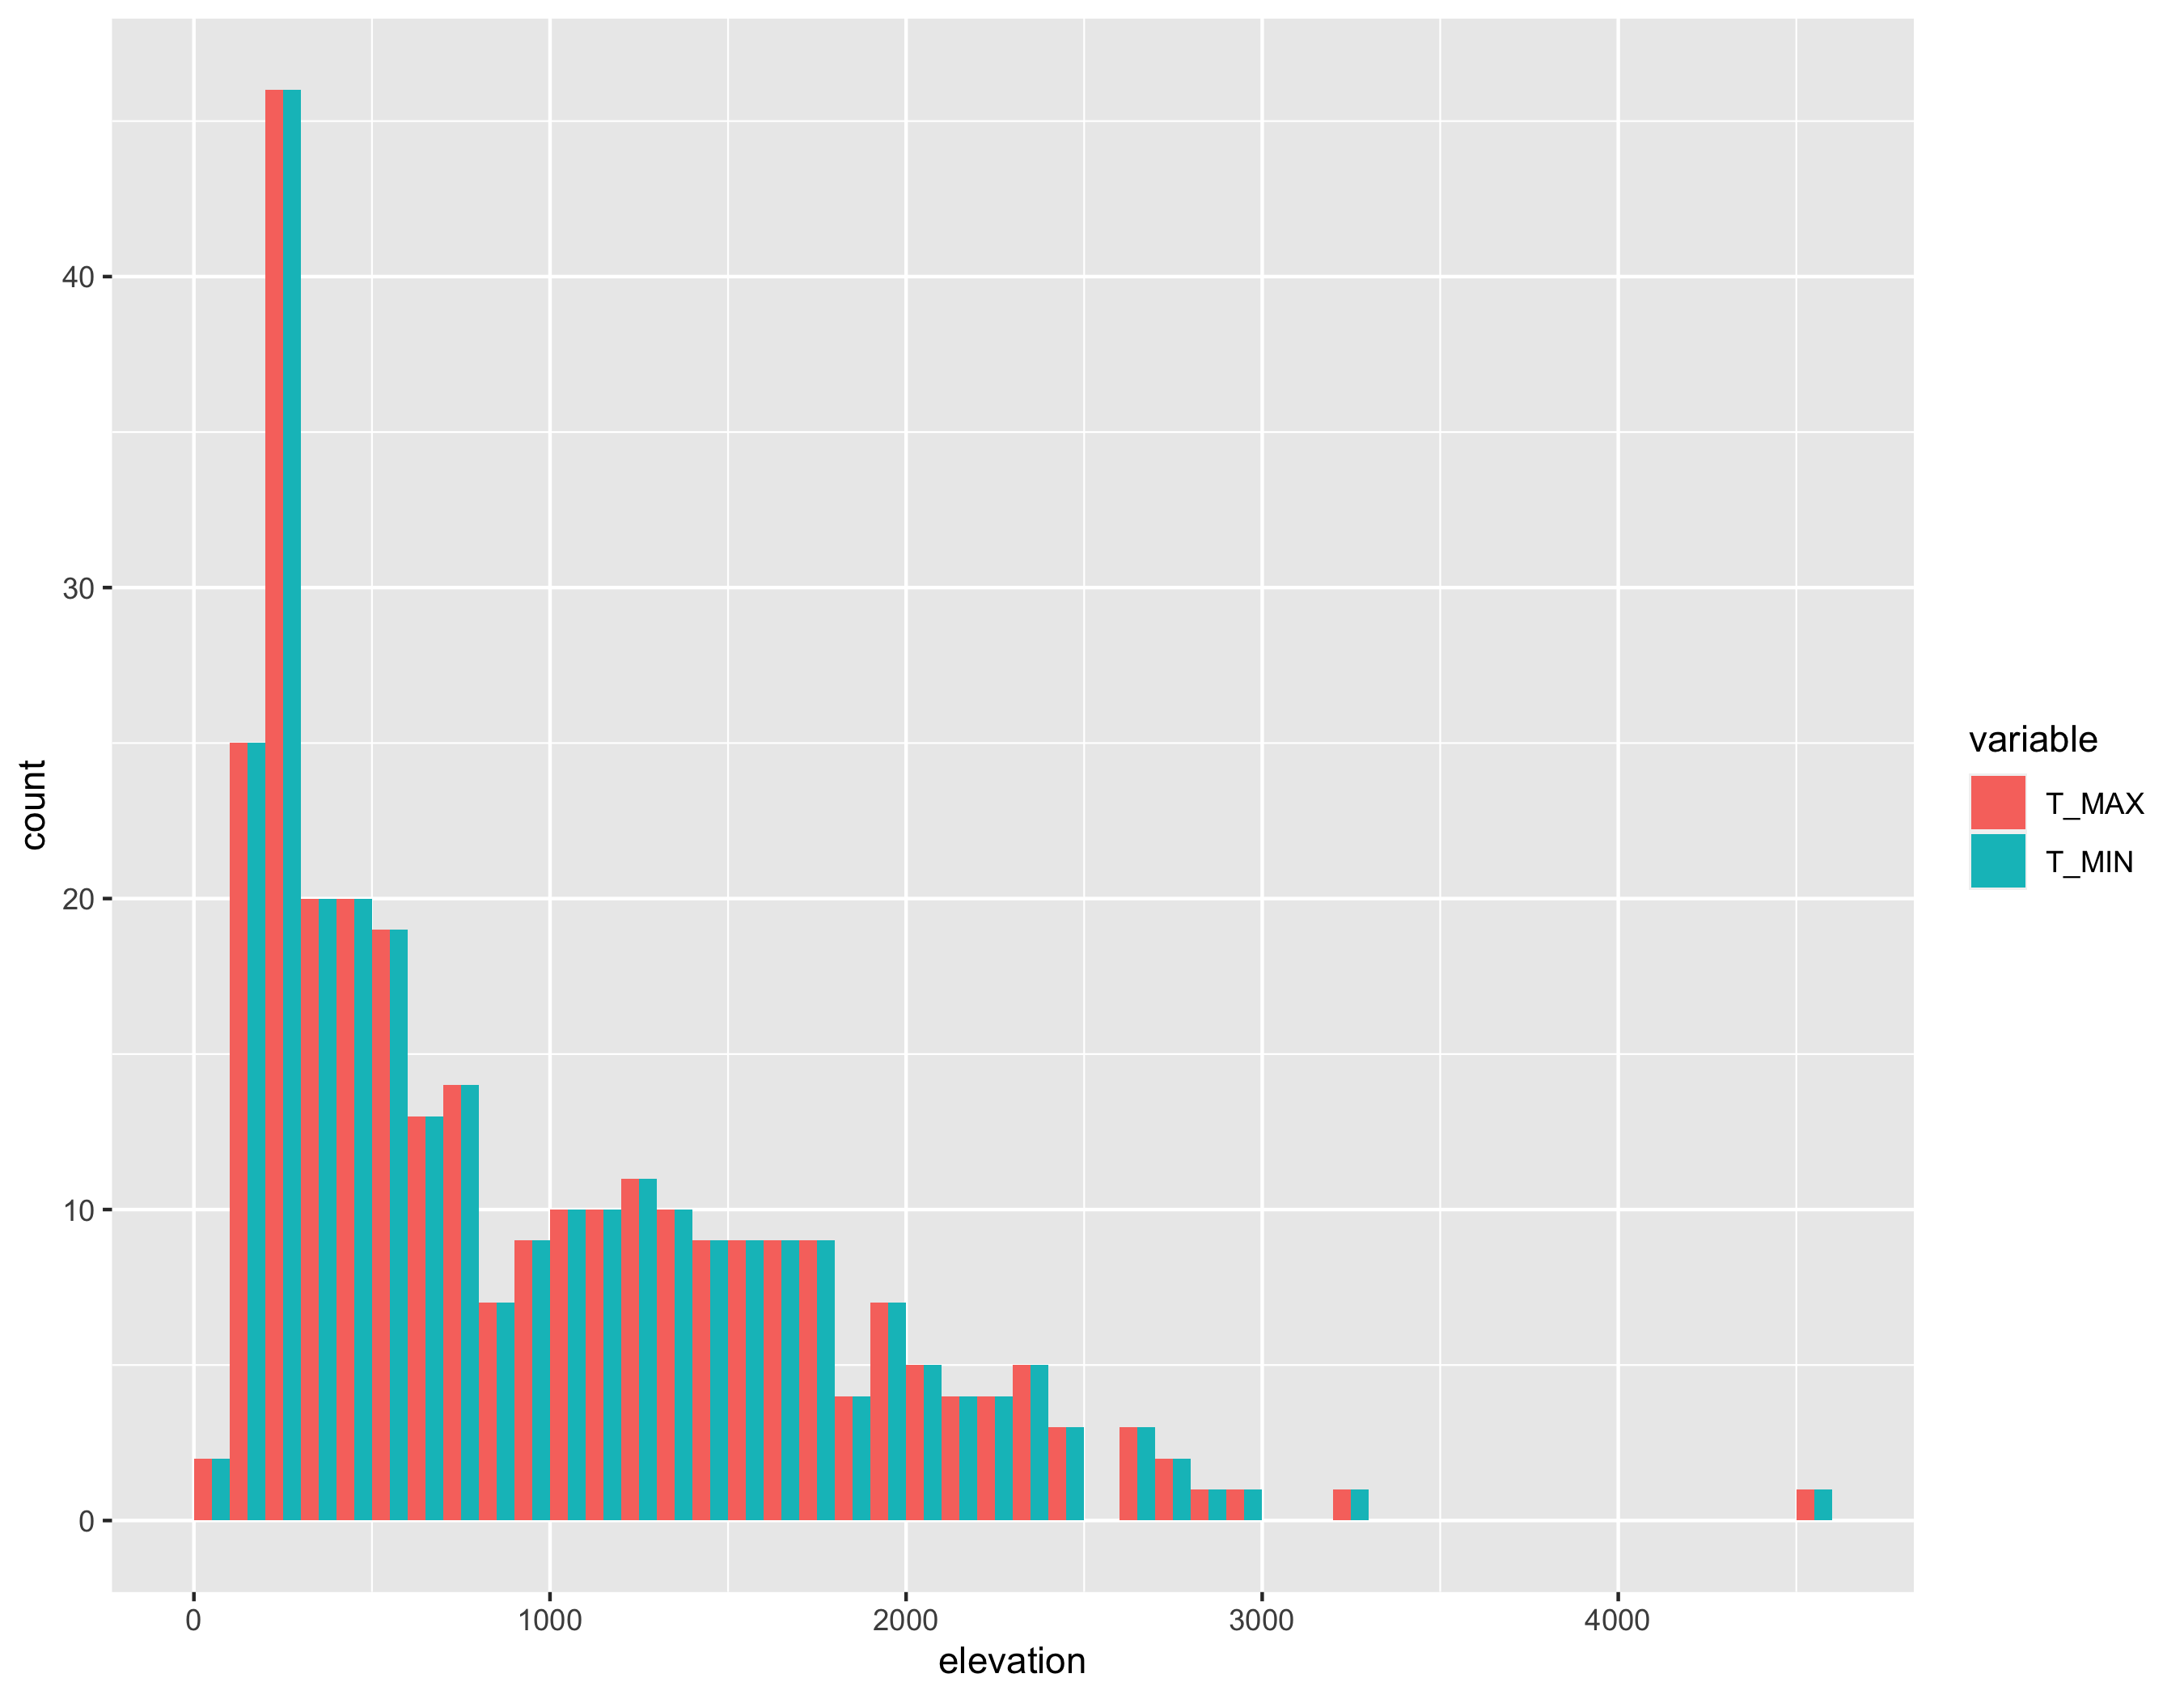

In [11]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())


In [48]:
db$meta |>
    collect() |>
    rowwise() |>
    filter(length(from_sensor_keys) == 1L) |>
    write.xlsx("pie.xlsx", asTable = TRUE)


In [19]:
tagged_analysis |>
    filter(user_code_x == user_code_y) |>
    write_xlsx_analysis("pie_same.xlsx", starts_with("user_code"), starts_with("tag_"))
